# Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

from keras.models import Sequential, Model
from keras.layers import Dense, Input

# Predicting the mean, standard deviation of 1D Gaussian

## Using Neural Nets

In [3]:
def predict(model):
    #pdb.set_trace()
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    pmeans, psigs = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(211)
    _, _, _ = plt.hist(predy[:, 0] - pmeans.flatten(), bins=30)
    plt.subplot(212)
    _, _, _ = plt.hist(predy[:, 1] - psigs.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    plt.subplot(211)
    # Plot the true y's and predicted y's from the NN model
    plt.plot(predy[:, 0], pmeans.flatten(), marker='.')
    # Plot the 1-to-1 line
    plt.plot(oto_means, oto_means, color='black', ls='--')
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\mu$')
    
    plt.subplot(212)
    plt.plot(predy[:, 1], psigs.flatten(), marker='.')
    plt.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    plt.xlim(0.25, 4.0)
    plt.ylim(0.25, 4.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\sigma$')
    
    #plt.savefig('gaussian_characteristics.pdf')
    plt.show()

### Generate Gaussian given mu, sigma

In [4]:
# Calculate a Gaussian given its mean and standard deviation
def gaussian(x_vals, mu, sigma):
    return np.exp(-0.5 * ((x_vals - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

# Make array that describes Gaussian
def make_gaussians(num, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0): 

    means = np.random.uniform(mu_min, mu_max, num)
    sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))

    for i in range(num):
        models[i] = gaussian(x_vals, means[i], sigmas[i])
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((means, sigmas)).T

    return models, targets

In [5]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000):
    X_train, y_train = make_gaussians(n_train)
    X_test, y_test = make_gaussians(n_test)
    
    return X_train, y_train, X_test, y_test

### Create, compile, fit, and evaluate NN model

In [13]:
# Check out: https://datascience.stackexchange.com/questions/28003/get-multiple-output-from-keras
# for multi-output regression using Keras NNs

def evaluate_model(X_train, y_train, X_test, y_test):
    # Create model
    
    # Here, this means that our training set of 10000 samples will be divided into
    # 10000/batch_size = 10000/10 = 1000 batches, each with 10 samples. The model
    # weights will be updated after each batch of 10.
    # One epoch will involve 1000 batches, or 1000 updates to the model
    # Since we are running 100 epochs, it will go through 100*1000 batches = 100,000 batches
    # during the entire process
    verbose, epochs, batch_size = 1, 100, 16
    input_shape = X_train.shape[1]

    inputs = Input(shape=(input_shape,))

    x = Dense(10, activation='relu')(inputs)
    x = Dense(5, activation='relu')(x)
    out1 = Dense(1, activation='linear', name='mean')(x)
    out2 = Dense(1, activation='linear', name='sigma')(x)

    # Create model with input layer and dense layers
    model = Model(inputs=inputs, outputs=[out1, out2])
    model.compile(loss='mse', optimizer='rmsprop')#, metrics=['accuracy'])

    # Fit model
    model.fit(X_train, [y_train[:,0], y_train[:,1]], epochs=epochs, verbose=verbose)
    
    # Run model on test set
    accuracy = model.evaluate(X_test, [y_test[:,0], y_test[:,1]], batch_size=batch_size, verbose=0)
    
    #print (model.metrics_names)
    predict(model)
    
    return accuracy

In [14]:
# If relevant, check accuracy of the model
def summarize_results(scores):
    #print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
    return

In [15]:
def detect_features(repeats=3):
    # Generate data
    X_train, y_train, X_test, y_test = generate_dataset()
    
    # Repeat experiment
    scores = list()
    
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        #pdb.set_trace()
        # **** score[0] below is currently the loss
        score = np.asarray(score[0]) #* 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
        
    # Summarize results
    #summarize_results(scores)
    
    return

Epoch 1/100
10000/10000 [==============================] - 1s 54us/step - loss: 3.5060 - mean_loss: 0.3457 - sigma_loss: 3.1564
Epoch 2/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.6203 - mean_loss: 0.1966 - sigma_loss: 0.4229
Epoch 3/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0999 - mean_loss: 0.0590 - sigma_loss: 0.0409
Epoch 4/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0256 - mean_loss: 0.0109 - sigma_loss: 0.0146
Epoch 5/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0089 - mean_loss: 0.0033 - sigma_loss: 0.0056
Epoch 6/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0051 - mean_loss: 0.0025 - sigma_loss: 0.0026
Epoch 7/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0042 - mean_loss: 0.0023 - sigma_loss: 0.0019
Epoch 8/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0038 - mean_loss: 0.00

10000/10000 [==============================] - 0s 43us/step - loss: 0.0012 - mean_loss: 4.4015e-04 - sigma_loss: 7.1050e-04
Epoch 63/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0011 - mean_loss: 4.3898e-04 - sigma_loss: 7.0191e-04
Epoch 64/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0011 - mean_loss: 4.4084e-04 - sigma_loss: 6.8673e-04
Epoch 65/100
10000/10000 [==============================] - 0s 41us/step - loss: 0.0011 - mean_loss: 4.3618e-04 - sigma_loss: 6.9347e-04
Epoch 66/100
10000/10000 [==============================] - 0s 40us/step - loss: 0.0011 - mean_loss: 4.3109e-04 - sigma_loss: 6.8420e-04
Epoch 67/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0011 - mean_loss: 4.2953e-04 - sigma_loss: 6.8238e-04
Epoch 68/100
10000/10000 [==============================] - 0s 40us/step - loss: 0.0011 - mean_loss: 4.3414e-04 - sigma_loss: 6.7894e-04
Epoch 69/100
10000/10000 [============================

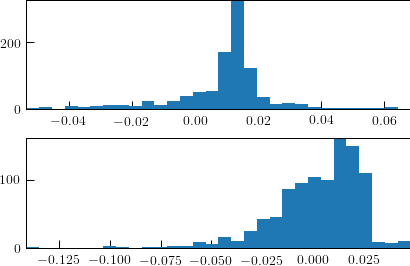

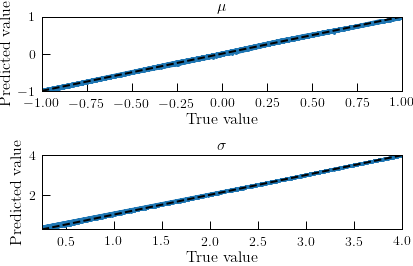

>#1: 0.001
Epoch 1/100
10000/10000 [==============================] - 1s 63us/step - loss: 2.3638 - mean_loss: 0.3183 - sigma_loss: 2.0427
Epoch 2/100
10000/10000 [==============================] - 0s 50us/step - loss: 0.2330 - mean_loss: 0.1445 - sigma_loss: 0.0882
Epoch 3/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0389 - mean_loss: 0.0257 - sigma_loss: 0.0132
Epoch 4/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0124 - mean_loss: 0.0054 - sigma_loss: 0.0070
Epoch 5/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0069 - mean_loss: 0.0024 - sigma_loss: 0.0046
Epoch 6/100
10000/10000 [==============================] - 0s 46us/step - loss: 0.0049 - mean_loss: 0.0016 - sigma_loss: 0.0033
Epoch 7/100
10000/10000 [==============================] - 0s 45us/step - loss: 0.0038 - mean_loss: 0.0013 - sigma_loss: 0.0025
Epoch 8/100
10000/10000 [==============================] - 0s 45us/step - loss: 0.0032 - mean

Epoch 61/100
10000/10000 [==============================] - 0s 45us/step - loss: 9.3521e-04 - mean_loss: 2.0458e-04 - sigma_loss: 7.3062e-04
Epoch 62/100
10000/10000 [==============================] - 0s 42us/step - loss: 9.2211e-04 - mean_loss: 2.0176e-04 - sigma_loss: 7.2048e-04
Epoch 63/100
10000/10000 [==============================] - 0s 41us/step - loss: 9.2030e-04 - mean_loss: 2.0716e-04 - sigma_loss: 7.1363e-04
Epoch 64/100
10000/10000 [==============================] - 0s 42us/step - loss: 9.1016e-04 - mean_loss: 2.0452e-04 - sigma_loss: 7.0509e-04
Epoch 65/100
10000/10000 [==============================] - 0s 45us/step - loss: 9.0126e-04 - mean_loss: 1.9229e-04 - sigma_loss: 7.0884e-04
Epoch 66/100
10000/10000 [==============================] - 0s 42us/step - loss: 9.1921e-04 - mean_loss: 2.0226e-04 - sigma_loss: 7.1629e-04
Epoch 67/100
10000/10000 [==============================] - 0s 40us/step - loss: 9.0317e-04 - mean_loss: 2.0153e-04 - sigma_loss: 7.0150e-04
Epoch 68/100


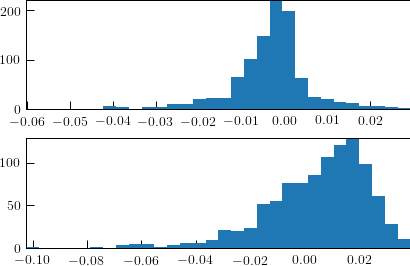

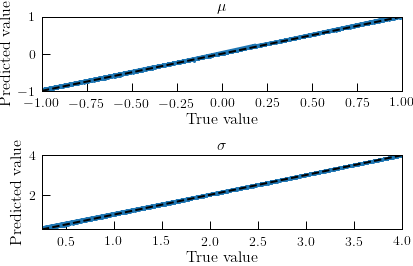

>#2: 0.000
Epoch 1/100
10000/10000 [==============================] - 1s 61us/step - loss: 2.0293 - mean_loss: 0.4417 - sigma_loss: 1.5855
Epoch 2/100
10000/10000 [==============================] - 0s 45us/step - loss: 0.2035 - mean_loss: 0.1462 - sigma_loss: 0.0570
Epoch 3/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0332 - mean_loss: 0.0251 - sigma_loss: 0.0081
Epoch 4/100
10000/10000 [==============================] - 0s 44us/step - loss: 0.0065 - mean_loss: 0.0034 - sigma_loss: 0.0031
Epoch 5/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0044 - mean_loss: 0.0021 - sigma_loss: 0.0024
Epoch 6/100
10000/10000 [==============================] - 0s 42us/step - loss: 0.0038 - mean_loss: 0.0018 - sigma_loss: 0.0020
Epoch 7/100
10000/10000 [==============================] - 0s 43us/step - loss: 0.0034 - mean_loss: 0.0016 - sigma_loss: 0.0018
Epoch 8/100
10000/10000 [==============================] - 0s 49us/step - loss: 0.0030 - mean

10000/10000 [==============================] - 0s 43us/step - loss: 7.8265e-04 - mean_loss: 2.5901e-04 - sigma_loss: 5.2290e-04
Epoch 61/100
10000/10000 [==============================] - 0s 44us/step - loss: 7.7617e-04 - mean_loss: 2.6208e-04 - sigma_loss: 5.1550e-04
Epoch 62/100
10000/10000 [==============================] - 0s 43us/step - loss: 7.7239e-04 - mean_loss: 2.5167e-04 - sigma_loss: 5.2012e-04
Epoch 63/100
10000/10000 [==============================] - 0s 42us/step - loss: 7.6981e-04 - mean_loss: 2.5949e-04 - sigma_loss: 5.0942e-04
Epoch 64/100
10000/10000 [==============================] - 0s 43us/step - loss: 7.5511e-04 - mean_loss: 2.5292e-04 - sigma_loss: 5.0154e-04
Epoch 65/100
10000/10000 [==============================] - 0s 41us/step - loss: 7.4528e-04 - mean_loss: 2.5310e-04 - sigma_loss: 4.9221e-04
Epoch 66/100
10000/10000 [==============================] - 0s 41us/step - loss: 7.3614e-04 - mean_loss: 2.4324e-04 - sigma_loss: 4.9409e-04
Epoch 67/100
10000/10000 [

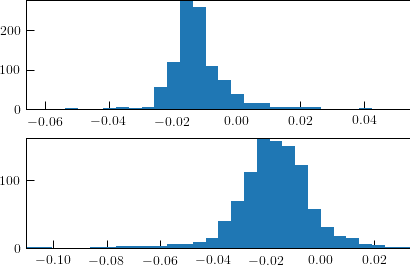

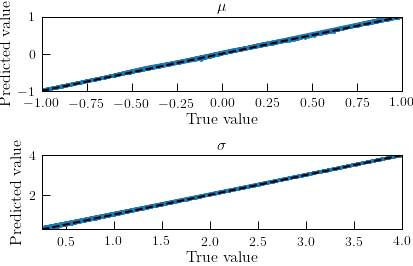

>#3: 0.001


In [16]:
detect_features()

## Using Support Vector Machines (SVM) for classification

### Support Vector Regression

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.

There are three different implementations of Support Vector Regression: SVR, NuSVR and LinearSVR. LinearSVR provides a faster implementation than SVR but only considers the linear kernel, while NuSVR implements a slightly different formulation than SVR and LinearSVR. See Implementation details for further details.

See Section 1.4.2 of https://scikit-learn.org/stable/modules/svm.html

### Create, compile, and fit model, and use it to predict

In [10]:
# Modelled this following the 'Separate Model for Each Output (MultiOutputRegressor)'
# section of https://machinelearningmastery.com/multi-output-regression-models-with-python/
# but changed LinearSVR to SVR
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

# create datasets
trainX, trainy, testX, testy = generate_dataset()

# define model
model = SVR(kernel='rbf')
wrapper = MultiOutputRegressor(model)

# fit model
wrapper.fit(trainX, trainy)

# make a prediction
yhat = wrapper.predict(testX)

# summarize prediction
#print(yhat)

#### Plot predictions vs true

In [24]:
x_vals = np.linspace(-10.0, 10.0, 32)

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


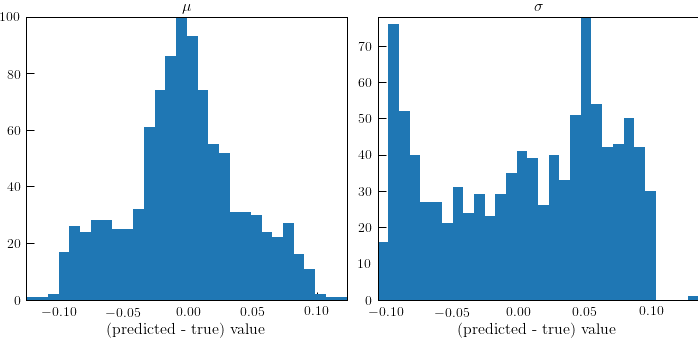

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(yhat[:, 0] - testy[:, 0], bins=30)
ax1.set_xlabel('(predicted - true) value')
ax1.set_title(r'$\mu$')

ax2.hist(yhat[:, 1] - testy[:, 1], bins=30)
ax2.set_xlabel('(predicted - true) value')
ax2.set_title(r'$\sigma$')

fig.show()

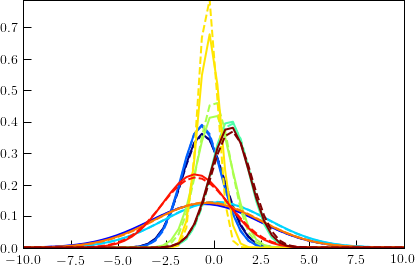

In [21]:
num_lines= yhat.shape[0]
cm_subsection = np.linspace(0.0, 1.0, 10) 

colors = [ cm.jet(x) for x in cm_subsection ]

# Plot the true Gaussians (solid lines) and predicted Gaussians (dashed lines) for a sample of 10
for i in range(0, 10):#testy.shape[0]):
    plt.plot(x_vals, gaussian(x_vals, yhat[i][0], yhat[i][1]), color=colors[i])
    plt.plot(x_vals, gaussian(x_vals, testy[i][0], testy[i][1]), color=colors[i], ls='--')
    
plt.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


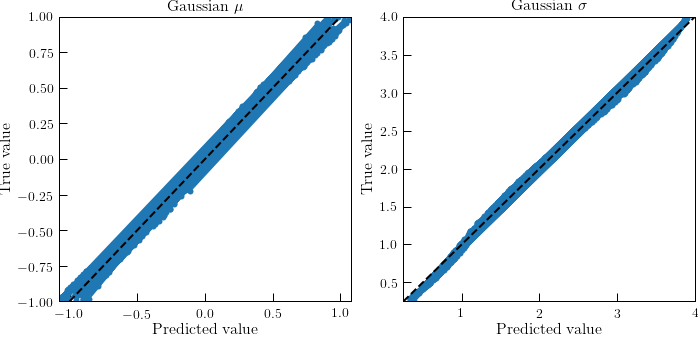

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(yhat[:,0], testy[:,0], marker='o')
ax1.plot(np.linspace(-1.0, 1.0), np.linspace(-1.0, 1.0), color='black', ls='--')
ax1.set_xlabel('Predicted value')
ax1.set_ylabel('True value')
ax1.set_title(r'Gaussian $\mu$')

ax2.plot(yhat[:,1], testy[:,1], marker='o')
ax2.plot(np.linspace(0.25, 4.0), np.linspace(0.25, 4.0), color='black', ls='--')
ax2.set_xlabel('Predicted value')
ax2.set_ylabel('True value')
ax2.set_title(r'Gaussian $\sigma$')

fig.show()